In [2]:
from helper_funcs import *

# Colourblind friendly colours
import tol_colors as tc
cset = tc.tol_cset('bright')
plt.rc('axes', prop_cycle=plt.cycler('color', list(cset)))

fsize = 24
plt.rcParams.update({'font.size': fsize})


dynamics_path = '../publication/dynamics/'
static_path = '../publication/static_tests/'

tmap = {
    'npt_000conEC_298K':'EMC (298$\,$K)',
    'npt_033conEC_298K':'EC:EMC (3:7) (298$\,$K)',
    'npt_066conEC_298K':'EC:EMC (7:3) (298$\,$K)',
    'npt_100conEC_313K':'EC (313$\,$K)',
}

conmap = {
    '000conEC':'EMC (298$\,$K)',
    '033conEC':'EC:EMC (3:7) (298$\,$K)',
    '066conEC':'EC:EMC (7:3) (298$\,$K)',
    '100conEC':'EC (313$\,$K)',
}

# Training error
Currently missing GAP resutls!

In [3]:
tags = [
    'IBM23/PBED3/SEED1/DSET1',
    'IBM23/PBED2/SEED1/DSET1',
    'IBM23/B97/SEED1/DSET1',
] # These tags needs to be adjusted to be compliant with zenodo

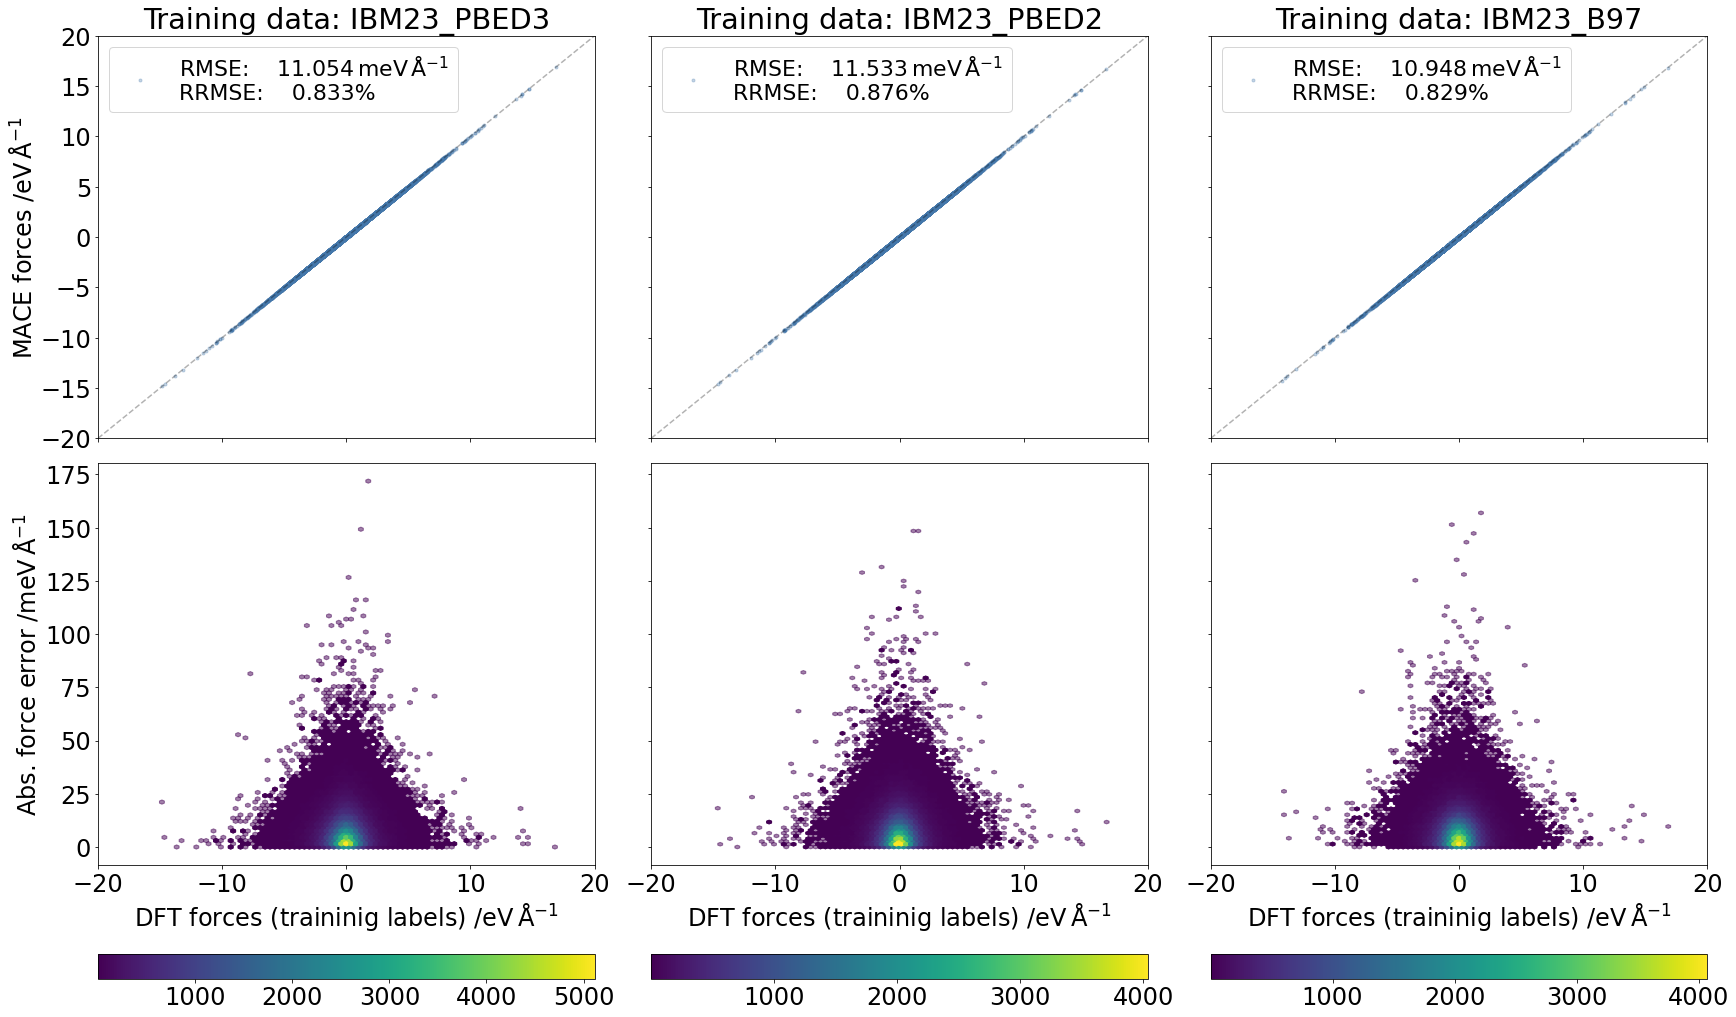

In [ ]:
# Obtain data and store to dicts
xyz = dict()
for tag in tags:
    xyz[tag] = get_xyz(f'{static_path}/{tag}/*') # Argument should be 'tag' to be consistent with zenodo


fig, axs = plt.subplots(2,len(tags), figsize=(8*len(tags), 7*2), sharex=True, sharey='row', layout='constrained')
for i, k in enumerate(xyz):
    tag = tags[i]
    atoms = xyz[k]
    data_set, functional, seed, dset_sample = tag.split('/')
    
    # Obtain forces and errors
    ## reference
    ref_forces = [a.arrays['forces'] for a in atoms if 'forces' in a.arrays.keys()]
    ref_forces = np.concatenate(ref_forces).flatten()

    ## mace
    mace_forces = [a.arrays['MACE_forces'] for a in atoms if 'forces' in a.arrays.keys()]
    mace_forces = np.concatenate(mace_forces).flatten()
    rmse, rrmse = RMSE(ref_forces, mace_forces)

    # Plot correlations
    axs[0,i].set_title(f'Training data: {data_set}_{functional}')
    axs[0,i].plot(ref_forces, mace_forces, '.', label=f'RMSE:    {rmse*1e3:.3f}$\\,$meV$\,$Å$^{{-1}}$\nRRMSE:    {rrmse*100:.3f}%', alpha=0.3)
    axs[0,i].legend(loc='upper left', numpoints=1, fontsize=fsize-2)

    # Plot settings
    axs[0,i].plot([0, 1], [0, 1], 'k--', transform=axs[0,i].transAxes, alpha=0.3)
    axs[0,i].set_xlim([-20,20])
    axs[0,i].set_ylim([-20,20])
    if i == 0: axs[0,i].set_ylabel('MACE forces /eV$\,$Å$^{-1}$')

    #if i == 0:
    #    h = axs[1,i].hexbin(ref_forces, abs(ref_forces-mace_forces)*1000, mincnt=1)
    #else:
    #    axs[1,i].hexbin(ref_forces, abs(ref_forces-mace_forces)*1000, mincnt=1)
    #h = axs[1,i].hexbin(ref_forces, abs(ref_forces-mace_forces)*1000, mincnt=1)
    h = axs[1,i].hexbin(ref_forces, abs(ref_forces-mace_forces)*1000, mincnt=1, alpha=0.5)
    h = axs[1,i].hexbin(ref_forces, abs(ref_forces-mace_forces)*1000, mincnt=2)
    plt.colorbar(h, ax=axs[1,i], orientation='horizontal')
    axs[1,i].set_xlabel('DFT forces (traininig labels) /eV$\,$Å$^{-1}$')
    axs[1,0].set_ylabel('Abs. force error /meV$\,$Å$^{-1}$')
    
#plt.colorbar(h, ax=axs[-1,-1])
#plt.tight_layout()

## A perspective on force errors
1. Calculate the average movement of an atom during a time step
2. Integrate the force along that distance to get the potential error in terms of an energy
3. Plot the correlation and determine the RMSE of this energy

In [4]:
xyz = dict()
for tag in tags:
    xyz[tag] = get_all_thermo(f'{dynamics_path}{tag}/*', xyz=True) # Argument should be 'tag' to be consistent with zenodo

In [ ]:
step_lengths = []
for tag, thermo_dict in xyz.items():
    for config, traj in thermo_dict.items():
        x = [a.positions for a in traj]
        dxdt = np.concatenate([dx/10 for dx in np.diff(x)])
        step_lengths.append(np.mean(dxdt))

#print(step_lengths)
avg_step_length = np.mean(np.abs(step_lengths))
#print(avg_step_length)
print(f'Avg. step length per atom per time step: {avg_step_length:.5f}')

Avg. step length per atom per time step: 0.02524


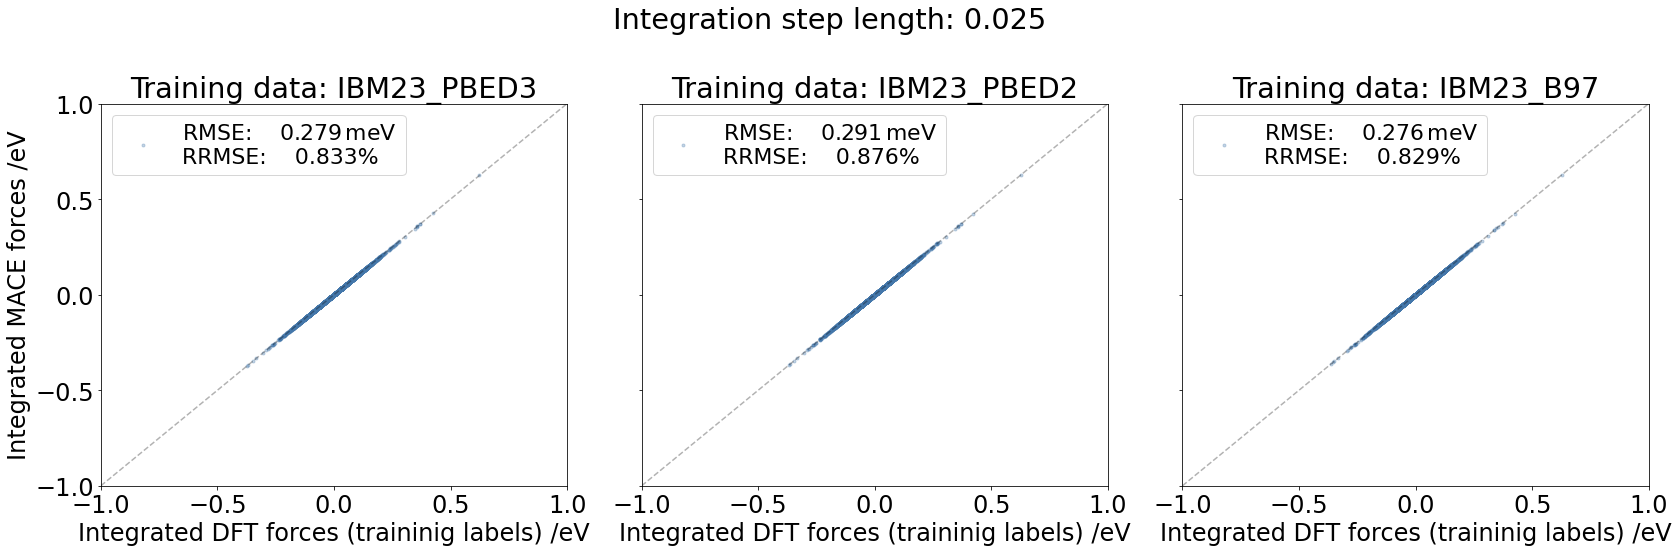

In [ ]:
step_length = 0.02524

# Obtain data and store to dicts
xyz = dict()
for tag in tags:
    xyz[tag] = get_xyz(f'{static_path}/{tag}/*') # Argument should be 'tag' to be consistent with zenodo


fig, axs = plt.subplots(1,len(tags), figsize=(8*len(tags), 8*1), sharex=True, sharey=True)
for i, k in enumerate(xyz):
    tag = tags[i]
    atoms = xyz[k]
    data_set, functional, seed, dset_sample = tag.split('/')
    
    # Obtain forces and errors
    ## reference
    ref_forces = [a.arrays['forces']*step_length for a in atoms if 'forces' in a.arrays.keys()]
    ref_forces = np.concatenate(ref_forces).flatten()

    ## mace
    mace_forces = [a.arrays['MACE_forces']*step_length for a in atoms if 'forces' in a.arrays.keys()]
    mace_forces = np.concatenate(mace_forces).flatten()
    rmse, rrmse = RMSE(ref_forces, mace_forces)

    # Plot correlations
    axs[i].set_title(f'Training data: {data_set}_{functional}')
    axs[i].plot(ref_forces, mace_forces, '.', label=f'RMSE:    {rmse*1e3:.3f}$\\,$meV\nRRMSE:    {rrmse*100:.3f}%', alpha=0.3)
    axs[i].legend(loc='upper left', numpoints=1, fontsize=fsize-2)

    # Plot settings
    axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.3)
    axs[i].set_xlabel('Integrated DFT forces (traininig labels) /eV')
    axs[i].set_xlim([-1,1])
    axs[i].set_ylim([-1,1])
    if i == 0: axs[i].set_ylabel('Integrated MACE forces /eV')

fig.suptitle(f'Integration step length: {step_length:.3f}')    
plt.tight_layout()

# NPT dynamics
Currently missing GAP results

In [3]:
thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(f'{dynamics_path}{tag}/*', xyz=False) # Argument should be 'tag' to be consistent with zenodo

## Determining diffusion limit start times
### Taken from *Best Practices for Computing Transport Properties 1. Self-Diffusivity and Viscosity from Equilibrium Molecular Dynamics [Article v1.0]*
#### 5.2.3 Data analysis
In order to obtain reliable estimates of D, it is important to consider how the linear regression is performed for the MSD with respect to time (Equation 2). Specifically, the time interval that is included in the regression can have a significant impact on the predicted value of D. We recommend that only the “middle” of the MSD be used in the fit to approximate the long-time slope. Short time must be excluded as it follows a ballistic trajectory, while very long time is excluded due to the increased noise. **Currently, we are unaware of an objective approach for defining the “middle” region. Until such an approach exists, we recommend that the author reports how the region was selected and how much variability in D can be attributed to the choice of this region**. In addition, the uncertainty in the fit of the slope should be reported.

A typical log-log plot, borrowed from Ref. [36], is provided in Figure 2, where the linear regression to the “middle” region is included. From visual inspection, the “ballistic” short-time interval ranges from the beginning of the simulation to approximately 100 ps. **The “middle” region is identified by the linear regime with a slope of 1 (for a log-log plot)** spanning from approximately 100 ps to 1000 ps. Note that the noisy “long-time” simulation data (beyond 1000 ps) are not depicted in Figure 2 and are excluded from the linear fit.

In [21]:
diff_coeffs = []
diff_errs = []
log_r2 = []
diff_r2 = []
diff_starts = []
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for j, (traj_name, traj_data) in enumerate(thermo[k].items()):

        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']
        
        idx, r2 = get_start_index(time,msd,threshold=1e-3, min_steps=5e3)
        if idx != None:   
            D, err, R2 = diffusion_coefficient(time[idx:],msd[idx:])
            diff_coeffs.append(D)
            diff_errs.append(err)
            log_r2.append(r2)
            diff_r2.append(R2)
            print(idx, len(time), r2, D, err, R2)
            diff_starts.append(idx)
        else:
            diff_coeffs.append(np.nan)
            diff_errs.append(np.nan)
            log_r2.append(np.nan)
            diff_r2.append(np.nan)
            diff_starts.append(np.nan)

Using slope error thresold of: 0.001
62240 99999 0.9736412184702987 1.5473933736847744e-09 1.5606628768202322e-11 0.9729796213119583
Using slope error thresold of: 0.001
14623 99999 0.9912270895522696 1.1372272122285182e-09 3.706553280202957e-12 0.9934848876966831
Using slope error thresold of: 0.001
53562 99999 0.9593598228374469 8.733158348761149e-10 9.924944394550886e-12 0.9584375223570128
Using slope error thresold of: 0.001
8791 99998 0.9859790330596564 6.961126751393844e-10 3.2586348517289704e-12 0.9857541177409838
Using slope error thresold of: 0.001
5263 99997 0.9835798009483161 1.3534975940217006e-09 6.144483101801675e-12 0.9860795077941075
Using slope error thresold of: 0.001
46078 99997 0.9817424636525158 8.023207194048369e-10 5.6714128453566366e-12 0.980891999681045
Using slope error thresold of: 0.001
13767 99997 0.9665566183976592 6.246728530790208e-10 3.261861137914213e-12 0.9832836321550157
Using slope error thresold of: 0.001
26571 99997 0.9891404223749826 4.9912190521

In [10]:
try:
    df = pd.read_pickle("./part1_func_res.pkl")
except:
    df, dunit = get_density(tags, dynamics_path, std=True)
    df['Diffusion coefficient'] = [d*1e10 for d in diff_coeffs] # 1e-6 cm2/s
    #df['Corr. diffusion coefficient'] = [fsize_correction(D,r) for D,r in df[['Diffusion coefficient', 'Avg. density']]]
    df['Diff. fit error'] = [e*1e10 for e in diff_errs] # 1e-6 cm2/s
    df['log-log r2'] = log_r2
    df['Diff. r2'] = diff_r2
    df['Diff. start time /ns'] = [time[s]*1e-6 if type(s) == int else np.nan for s in diff_starts]
    pd.to_pickle(df, "./part1_func_res.pkl")
df.style.map(rvalue_formatting, subset=['log-log r2', 'Diff. r2'])

,Train data,Functional,Seed,Sample,Composition,Avg. density,Std. density,Diffusion coefficient,Diff. fit error,log-log r2,Diff. r2,Diff. start time /ns
0,IBM23,PBED3,1,1,"EMC (298$\,$K)",0.965048,0.016399,15.473934,0.156066,0.973641,0.972980,0.622410
1,IBM23,PBED3,1,1,"EC:EMC (3:7) (298$\,$K)",1.040782,0.016999,11.372272,0.037066,0.991227,0.993485,0.146230
2,IBM23,PBED3,1,1,"EC:EMC (7:3) (298$\,$K)",1.129481,0.015671,8.733158,0.099249,0.959360,0.958438,0.535630
3,IBM23,PBED3,1,1,"EC (313$\,$K)",1.232997,0.016728,6.961127,0.032586,0.985979,0.985754,0.087910
4,IBM23,PBED2,1,1,"EMC (298$\,$K)",1.047056,0.016843,13.534976,0.061445,0.983580,0.986080,0.052630
5,IBM23,PBED2,1,1,"EC:EMC (3:7) (298$\,$K)",1.129350,0.015385,8.023207,0.056714,0.981742,0.980892,0.460790
6,IBM23,PBED2,1,1,"EC:EMC (7:3) (298$\,$K)",1.225467,0.015899,6.246729,0.032619,0.966557,0.983284,0.137670
7,IBM23,PBED2,1,1,"EC (313$\,$K)",1.337139,0.015780,4.991219,0.022593,0.989140,0.989239,0.265710
8,IBM23,B97,1,1,"EMC (298$\,$K)",1.089476,0.016971,5.924351,0.050191,0.979106,0.976648,0.539230
9,IBM23,B97,1,1,"EC:EMC (3:7) (298$\,$K)",1.149753,0.015724,4.696002,0.071052,0.949866,0.954458,0.711700


## Results

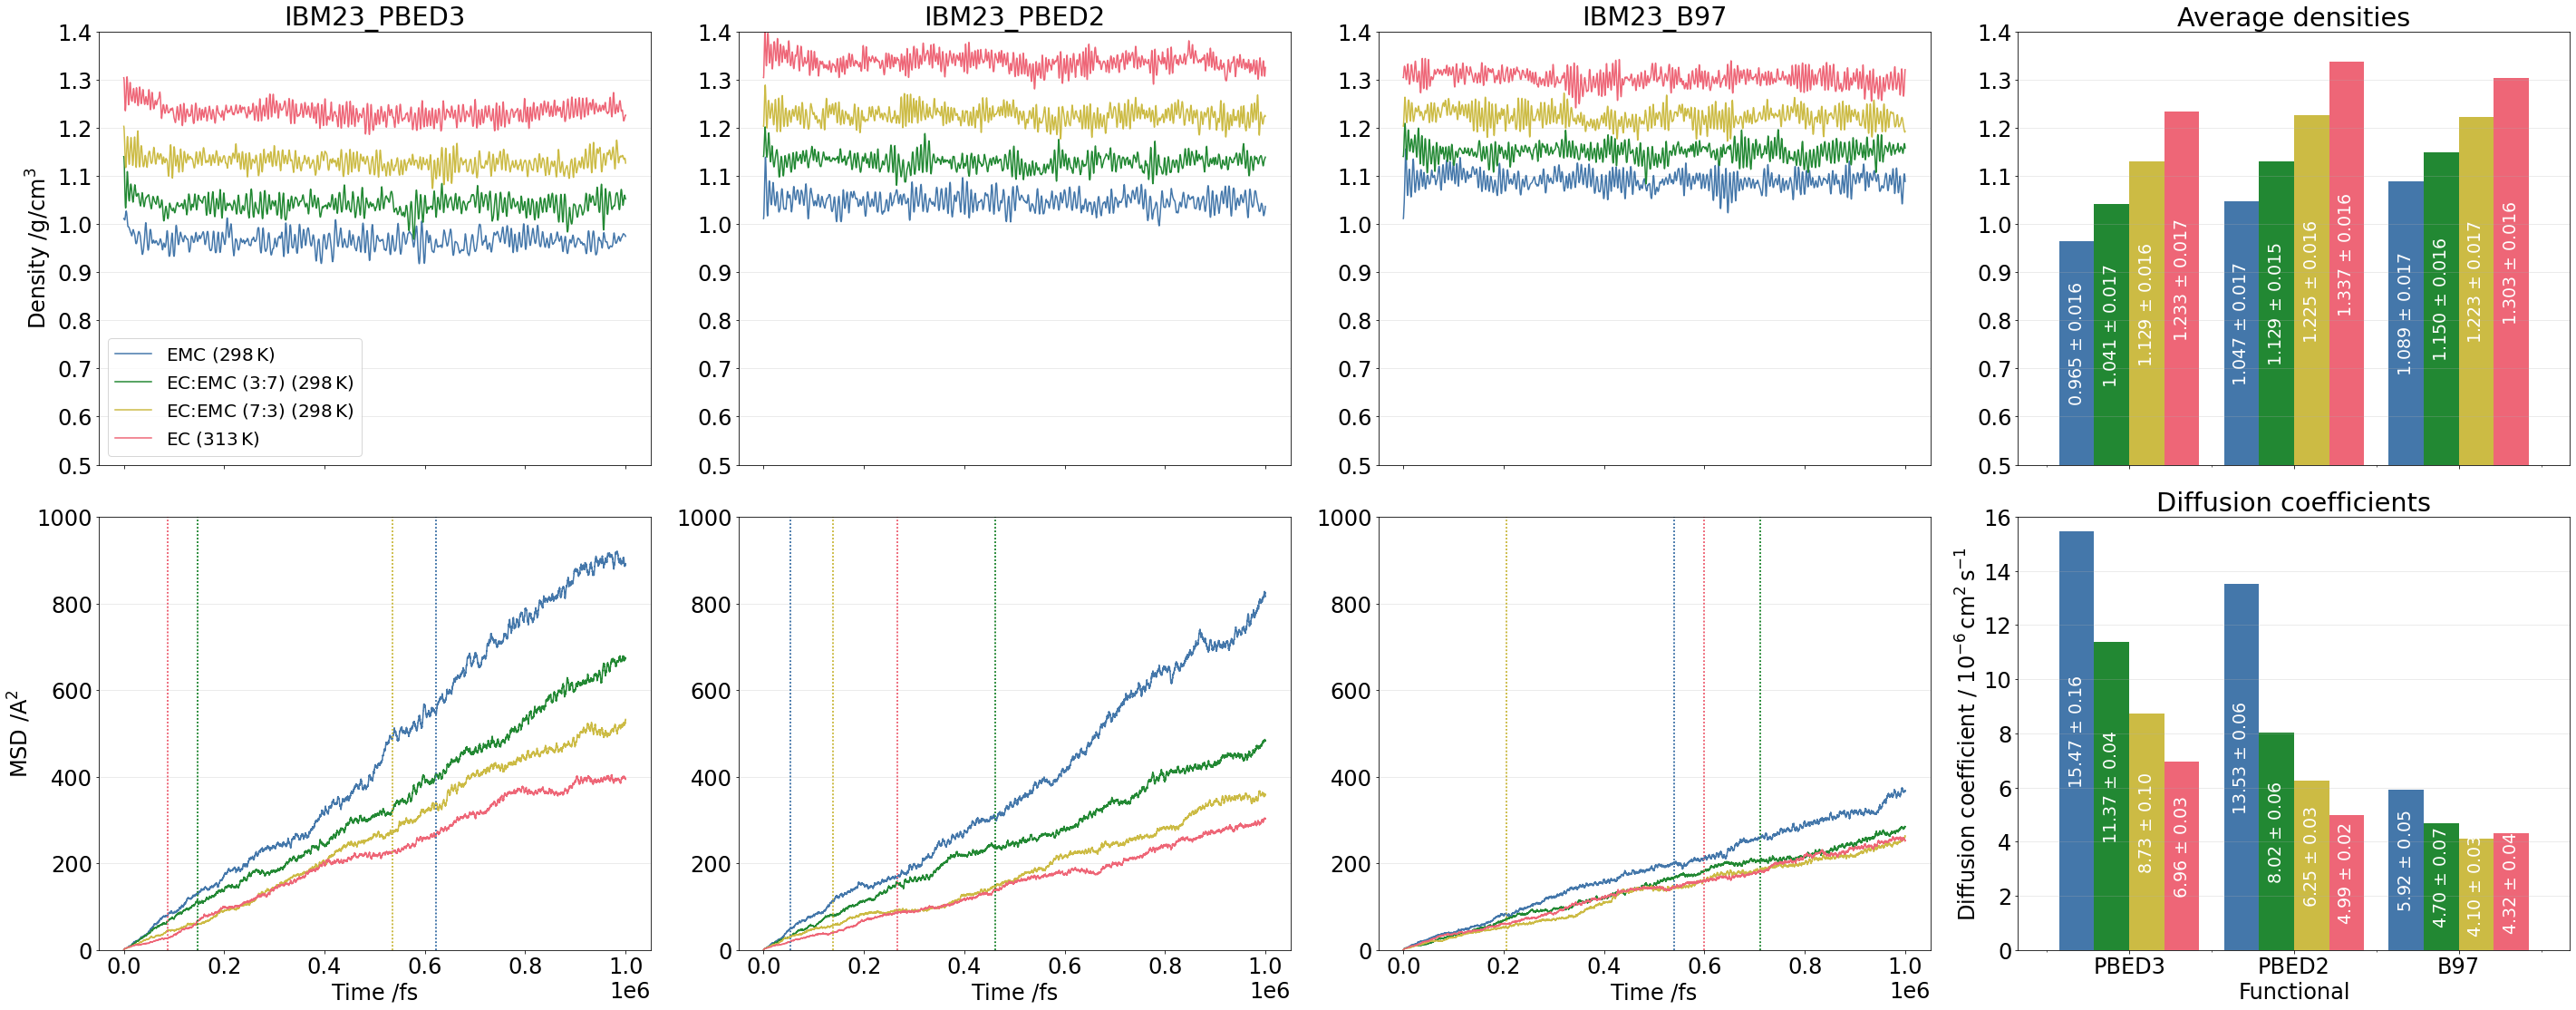

In [13]:
plt.rcParams.update({'font.size': fsize})

order = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

# Pivot tables for plotting
avg_pivot_df = df.pivot(
	index='Functional',
	columns='Composition',
	values='Avg. density',
).sort_index(axis=0,ascending=False)[order]

std_pivot_df = df.pivot(
	index='Functional',
	columns='Composition',
	values='Std. density',
).sort_index(axis=0,ascending=False)[order]


diff_pivot_df = df.pivot(
	index='Functional',
	columns='Composition',
	values='Diffusion coefficient',
	#values=['Avg. density', 'Var.'],
).sort_index(axis=0,ascending=False)[order]

differr_pivot_df = df.pivot(
	index='Functional',
	columns='Composition',
	values='Diff. fit error',
).sort_index(axis=0,ascending=False)[order]


fig, axs = plt.subplots(2,len(tags)+1, figsize=(10*(len(tags)+1), 8*2), sharex='col')
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for j, (traj_name, traj_data) in enumerate(thermo[k].items()):
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']

        # Plot density
        axs[0,i].set_ylim([0.5, 1.4])
        if i == 0: axs[0,i].set_ylabel(f'Density /{dunit}')
        axs[0,i].plot(time,dens, label=tmap[traj_name], color=get_colour(traj_name))

        # Plot MSD
        axs[1,i].set_ylim([0, 1000])
        if i == 0: axs[1,i].set_ylabel(f'MSD /{munit}')
        axs[1,i].plot(time,msd, label=tmap[traj_name], color=get_colour(traj_name))

        axs[1,0].axvline(df['Diff. start time /ns'].iloc[j]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        axs[1,1].axvline(df['Diff. start time /ns'].iloc[j+4]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        axs[1,2].axvline(df['Diff. start time /ns'].iloc[j+8]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')

        # Shared plot setings
        axs[0,i].set_title(f'{data_set}_{functional}')
        axs[1,i].set_xlabel(f'Time /{tunit}')
        axs[0,i].grid(axis='y', alpha=0.3)
        axs[1,i].grid(axis='y', alpha=0.3)

#axs[-1,-1].legend(loc='upper left')

axs[0,-1].set_title('Average densities')
a0 = avg_pivot_df.plot.bar(
    ylim=[0.5,1.4],
    xlabel='',
    rot=0,
    width=0.85,
    color=[get_colour(o) for o in order],
    ax=axs[0,-1],
    legend=False,
)
axs[0,-1].grid(axis='y', alpha=0.3)

axs[1,-1].set_title('Diffusion coefficients')
a1 = diff_pivot_df.plot.bar(
    ylim=[0,16],
    ylabel=f'Diffusion coefficient / $10^{{-6}}\\,\\text{{cm}}^2\\,\\text{{s}}^{{-1}}$',
    rot=0,
    width=0.85,
    color=[get_colour(o) for o in order],
    ax=axs[1,-1],
    legend=False,
)

for i, (c0,c1) in enumerate(zip(a0.containers, a1.containers)):
    col_name = avg_pivot_df.columns[i]
    dens_vals = avg_pivot_df[col_name]
    dens_errs = std_pivot_df[col_name]
    dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]

    diff_vals = diff_pivot_df[col_name]
    diff_errors = differr_pivot_df[col_name]
    diff_labels = [f'{v:.2f} $\\pm$ {e:.2f}' for v, e in zip(diff_vals, diff_errors)]

    axs[0,-1].bar_label(c0, rotation=90, fontsize=fsize-5, label_type='center', padding=10, labels=dens_labels, color='white')
    axs[1,-1].bar_label(c1, rotation=90, fontsize=fsize-5, label_type='center', padding=10, labels=diff_labels, color='white')
    #axs[1,-1].bar_label(c1, rotation=90, fontsize=fsize-6, label_type='center', fmt='%.3f', padding=10, color='white')

axs[0,0].legend(loc='lower left', fontsize=fsize-4)
axs[1,-1].grid(axis='y', alpha=0.3)
plt.tight_layout()

# Molecular radial distributions

In [31]:
def get_mol_positions(atoms):
	positions = []
	mol_set = set(atoms.arrays['molID'])
	for ID in mol_set:
		mol = atoms[atoms.arrays['molID'] == ID]
		com = mol.get_center_of_mass()
		positions.append(com)
	positions = np.array(positions)
	return positions, len(mol_set)

def mol_rdf(atoms, rcut, bins, return_num_mols=False):
	positions, num_mols = get_mol_positions(atoms)
	box_length = atoms.get_volume()**(1/3)
	if rcut is None: rcut=box_length
	for i, p in enumerate(positions):
		# PBC
		delta = positions[i+1:]-positions[i]
		delta -= box_length*np.round(delta/box_length)
		
		# Get counts
		dists = np.linalg.norm(delta, axis=1)
		s = sorted(dists[dists <= rcut])[1:]
		if i == 0:
			counts, bins = np.histogram(s, bins, (0,rcut))
		else:
			counts += np.histogram(s, bins, (0,rcut))[0]
	if return_num_mols:
		return counts, bins, num_mols
	else:
		return counts, bins

def compute_rdf(traj, rcut=None, bins=100):
	for i, atoms in enumerate(traj):
		if i == 0:
			counts, bins, nmols= mol_rdf(atoms, rcut=rcut, bins=bins, return_num_mols=True)			
			volume = atoms.get_volume()
			box_length = volume**(1/3)
			r = 0.5*(bins[1:]+bins[:-1])
			shell_volume = 4/3*np.pi*(bins[1:]**3-bins[:-1]**3)
			number_density = nmols/volume
			ideal_gas = number_density*shell_volume
		else:
			counts += mol_rdf(atoms, rcut=rcut, bins=bins)[0]
	g = counts/(ideal_gas*nmols)
	return g, r

In [ ]:
rdfs = {}
for tag in tags:
    data_set, functional, seed, dset_sample = tag.split('/')
    flist = [name for name in glob.glob(f'{dynamics_path}{tag}/*') if '.xyz' in name]
    print(f'{data_set}_{functional}')
    rdfs[f'{data_set}_{functional}'] = {}
    for file in flist:
        print(file)
        comp = file.split('/')[-1].split('.')[0][4:-5]
        comp = conmap[comp]
        traj = read(file, ':')
        aa.find_molecs(traj, fct=1.0)
        g, r = compute_rdf(traj, rcut=11)
        rdfs[f'{data_set}_{functional}'][comp] = g
        del traj

IBM23_PBED3
../publication/dynamics/IBM23/PBED3/SEED1/DSET1/npt_000conEC_298K.xyz
../publication/dynamics/IBM23/PBED3/SEED1/DSET1/npt_033conEC_298K.xyz
../publication/dynamics/IBM23/PBED3/SEED1/DSET1/npt_066conEC_298K.xyz
../publication/dynamics/IBM23/PBED3/SEED1/DSET1/npt_100conEC_313K.xyz
IBM23_PBED2
../publication/dynamics/IBM23/PBED2/SEED1/DSET1/npt_000conEC_298K.xyz
../publication/dynamics/IBM23/PBED2/SEED1/DSET1/npt_033conEC_298K.xyz
../publication/dynamics/IBM23/PBED2/SEED1/DSET1/npt_066conEC_298K.xyz


# Latex tables for paper

In [45]:
def functional_density(df, functional, composition):
    comp_mask = df['Composition'] == composition
    func_mask = df['Functional'] == functional
    selection = df[comp_mask & func_mask]['Avg. density']
    #return round(selection.iloc[0], precision)
    return selection.iloc[0]


configs = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

data = {
    'Functional pair':['\PBE{2} and \PBE{3}', '\PBE{2} and \BNS', '\PBE{3} and \BNS'],
}

for config in configs:
    PBED2_dens = functional_density(df, 'PBED2', config)
    PBED3_dens = functional_density(df, 'PBED3', config)
    B97D3_dens = functional_density(df, 'B97', config)
    data[config] = [abs(PBED2_dens-PBED3_dens),abs(PBED2_dens-B97D3_dens),abs(PBED3_dens-B97D3_dens)]
    print(config)
    print(f'PBED2-PBED3 diff.: {abs(PBED2_dens-PBED3_dens):.4f} g/mL')
    print(f'PBED2-B97D3 diff.: {abs(PBED2_dens-B97D3_dens):.4f} g/mL')
    print(f'PBED3-B97D3 diff.: {abs(PBED3_dens-B97D3_dens):.4f} g/mL\n')

dens_df = pd.DataFrame(data).round(decimals=3)
print(dens_df.to_latex(index=False))

EMC (298$\,$K)
PBED2-PBED3 diff.: 0.0820 g/mL
PBED2-B97D3 diff.: 0.0424 g/mL
PBED3-B97D3 diff.: 0.1244 g/mL

EC:EMC (3:7) (298$\,$K)
PBED2-PBED3 diff.: 0.0886 g/mL
PBED2-B97D3 diff.: 0.0204 g/mL
PBED3-B97D3 diff.: 0.1090 g/mL

EC:EMC (7:3) (298$\,$K)
PBED2-PBED3 diff.: 0.0960 g/mL
PBED2-B97D3 diff.: 0.0027 g/mL
PBED3-B97D3 diff.: 0.0933 g/mL

EC (313$\,$K)
PBED2-PBED3 diff.: 0.1041 g/mL
PBED2-B97D3 diff.: 0.0345 g/mL
PBED3-B97D3 diff.: 0.0697 g/mL

\begin{tabular}{lrrrr}
\toprule
Functional pair & EMC (298$\,$K) & EC:EMC (3:7) (298$\,$K) & EC:EMC (7:3) (298$\,$K) & EC (313$\,$K) \\
\midrule
\PBE{2} and \PBE{3} & 0.082000 & 0.089000 & 0.096000 & 0.104000 \\
\PBE{2} and \BNS & 0.042000 & 0.020000 & 0.003000 & 0.034000 \\
\PBE{3} and \BNS & 0.124000 & 0.109000 & 0.093000 & 0.070000 \\
\bottomrule
\end{tabular}



In [48]:
def functional_diffusivity(df, functional, composition):
    comp_mask = df['Composition'] == composition
    func_mask = df['Functional'] == functional
    selection = df[comp_mask & func_mask]['Diffusion coefficient']
    return selection.iloc[0]


configs = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

data = {
    'Functional pair':['\PBE{2} and \PBE{3}', '\PBE{2} and \BNS', '\PBE{3} and \BNS'],
}

for config in configs:
    PBED2_diff = functional_diffusivity(df, 'PBED2', config)
    PBED3_diff = functional_diffusivity(df, 'PBED3', config)
    B97D3_diff = functional_diffusivity(df, 'B97', config)
    data[config] = [abs(PBED2_diff-PBED3_diff),abs(PBED2_diff-B97D3_diff),abs(PBED3_diff-B97D3_diff)]
    print(config)
    print(f'PBED2-PBED3 diff.: {abs(PBED2_diff-PBED3_diff):.4f}*1e-6 cm2/s')
    print(f'PBED2-B97D3 diff.: {abs(PBED2_diff-B97D3_diff):.4f}*1e-6 cm2/s')
    print(f'PBED3-B97D3 diff.: {abs(PBED3_diff-B97D3_diff):.4f}*1e-6 cm2/s\n')

diff_df = pd.DataFrame(data).round(decimals=4)
print(diff_df.to_latex(index=False))

EMC (298$\,$K)
PBED2-PBED3 diff.: 1.9390*1e-6 cm2/s
PBED2-B97D3 diff.: 7.6106*1e-6 cm2/s
PBED3-B97D3 diff.: 9.5496*1e-6 cm2/s

EC:EMC (3:7) (298$\,$K)
PBED2-PBED3 diff.: 3.3491*1e-6 cm2/s
PBED2-B97D3 diff.: 3.3272*1e-6 cm2/s
PBED3-B97D3 diff.: 6.6763*1e-6 cm2/s

EC:EMC (7:3) (298$\,$K)
PBED2-PBED3 diff.: 2.4864*1e-6 cm2/s
PBED2-B97D3 diff.: 2.1468*1e-6 cm2/s
PBED3-B97D3 diff.: 4.6333*1e-6 cm2/s

EC (313$\,$K)
PBED2-PBED3 diff.: 1.9699*1e-6 cm2/s
PBED2-B97D3 diff.: 0.6685*1e-6 cm2/s
PBED3-B97D3 diff.: 2.6384*1e-6 cm2/s

\begin{tabular}{lrrrr}
\toprule
Functional pair & EMC (298$\,$K) & EC:EMC (3:7) (298$\,$K) & EC:EMC (7:3) (298$\,$K) & EC (313$\,$K) \\
\midrule
\PBE{2} and \PBE{3} & 1.939000 & 3.349100 & 2.486400 & 1.969900 \\
\PBE{2} and \BNS & 7.610600 & 3.327200 & 2.146800 & 0.668500 \\
\PBE{3} and \BNS & 9.549600 & 6.676300 & 4.633300 & 2.638400 \\
\bottomrule
\end{tabular}

